In [1]:
import os
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cuda'


In [30]:
from PIL import Image
import numpy as np
import tarfile

# 下載 dataset
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
import os
import urllib
from urllib.request import urlretrieve
def reporthook(a,b,c):
    print("\rdownloading: %5.1f%%"%(a*b*100.0/c), end="")
tar_gz = "cifar-10-python.tar.gz"
if not os.path.isfile(tar_gz):
        print('Downloading data from %s' % url)
        urlretrieve(url, tar_gz, reporthook=reporthook)

import pickle
train_X=[]
train_y=[]
tar_gz = "cifar-10-python.tar.gz"
with tarfile.open(tar_gz) as tarf:
    for i in range(1, 6):
        dataset = "cifar-10-batches-py/data_batch_%d"%i
        print("load",dataset)
        with tarf.extractfile(dataset) as f:
            result = pickle.load(f, encoding='latin1')
        train_X.extend( result['data'].reshape(-1,3,32,32)/255*2-1)
        train_y.extend(result['labels'])
    train_X=np.float32(train_X)
    train_y=np.int32(train_y)
    dataset = "cifar-10-batches-py/test_batch"
    print("load",dataset)
    with tarf.extractfile(dataset) as f:
        result = pickle.load(f, encoding='latin1')
        test_X=np.float32(result['data'].reshape(-1,3,32,32)/255*2-1)
        test_y=np.int32(result['labels'])
train_X = np.concatenate([train_X, test_X])
train_X = np.concatenate([train_X[:,:,:,::-1], train_X])
train_y = np.concatenate([train_y, test_y, train_y, test_y])
train_Y = np.eye(10).astype('float32')[train_y]

load cifar-10-batches-py/data_batch_1
load cifar-10-batches-py/data_batch_2
load cifar-10-batches-py/data_batch_3
load cifar-10-batches-py/data_batch_4
load cifar-10-batches-py/data_batch_5
load cifar-10-batches-py/test_batch


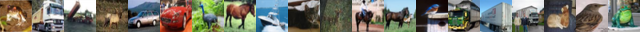

[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]
['青蛙' '卡車' '卡車' '鹿' '汽車' '汽車' '鳥' '馬' '船' '貓' '鹿' '馬' '馬' '鳥' '卡車' '卡車'
 '卡車' '貓' '鳥' '青蛙']


In [3]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    int_X = np.moveaxis(int_X, 1, 3)
    int_X_reshape = int_X.reshape(rows, -1, 32, 32,3).swapaxes(1,2).reshape(rows*32,-1, 3)
    display(Image.fromarray(int_X_reshape))
# 訓練資料， X 的前 20 筆
showX(train_X[:20])
print(train_y[:20])
name_array = np.array("飛機、汽車、鳥、貓、鹿、狗、青蛙、馬、船、卡車".split('、'))
print(name_array[train_y[:20]])

In [4]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import DenseLayer, DropoutLayer, ReshapeLayer, InputLayer, FlattenLayer, Upscale2DLayer, LocalResponseNormalization2DLayer
floatX = theano.config.floatX
from lasagne.layers import MaxPool2DLayer, Conv2DLayer, TransposedConv2DLayer
from lasagne.layers import batch_norm

Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 980 (0000:01:00.0)


In [5]:
conv_init = lasagne.init.Normal(0.05, 0)
gamma_init = lasagne.init.Normal(0.02, 1)

In [6]:
def DCGAN_DC(isize, nz, nc, ndf, n_discrete, n_extra_layers=0):
    _ = InputLayer(shape=(None, nc, isize, isize))
    _ = Conv2DLayer(_, num_filters=ndf, filter_size=4, stride=2, pad=1, b=None, W=conv_init, flip_filters=False,
               name = 'initial.conv.{0}-{1}'.format(nc, ndf), 
                nonlinearity=lasagne.nonlinearities.LeakyRectify(0.2))
    csize, cndf = isize // 2, ndf
    while csize > 5:
        in_feat = cndf
        out_feat = cndf*2
        _ = Conv2DLayer(_, num_filters=out_feat, filter_size=4, stride=2, pad=1, b=None, W=conv_init, 
                                   flip_filters=False,
               name = 'pyramid.{0}-{1}.conv'.format(in_feat, out_feat), 
                nonlinearity=lasagne.nonlinearities.LeakyRectify(0.2))
        if 0: # change this line to turn on batch_norm
            _ = batch_norm(_, epsilon=1e-5)
        csize, cndf = csize//2, cndf*2
        
    D = Conv2DLayer(_, num_filters=1, filter_size=csize, stride=1, pad=0, b=None, W=conv_init, 
                    flip_filters=False,
               name = 'final.{0}-{1}.conv'.format(cndf, 1), 
                nonlinearity=None)
    D = FlattenLayer(D)
    C = Conv2DLayer(_, num_filters=cndf, filter_size=csize, stride=1, pad=0, b=None, W=conv_init, 
                    flip_filters=False,
               name = 'final.{0}-{1}.conv'.format(cndf, cndf), 
                nonlinearity=lasagne.nonlinearities.LeakyRectify(0.2))
    C = FlattenLayer(C)
    C = DenseLayer(C, 10, nonlinearity=lasagne.nonlinearities.softmax)    
    return D, C


In [7]:
def DCGAN_G(isize, nz, nc, ngf, n_extra_layers=0):
    cngf= ngf//2
    tisize = isize
    while tisize > 5:
        cngf = cngf * 2
        tisize = tisize // 2
    _ = InputLayer(shape=(None, nz))
    _ = ReshapeLayer(_, (-1, nz, 1,1))
    _ = TransposedConv2DLayer(_, num_filters=cngf, filter_size=tisize, stride=1, crop=0, b=None, 
                              W=conv_init,
               name =  'initial.{0}-{1}.convt'.format(nz, cngf))
    _ = batch_norm(_, epsilon=1e-5)
    csize, cndf = tisize, cngf
    
    while csize < isize//2:
        in_feat = cngf
        out_feat = cngf//2
        _ = TransposedConv2DLayer(_, num_filters=out_feat, filter_size=4, stride=2, crop=1, b=None, W=conv_init,
               name = 'pyramid.{0}-{1}.convt'.format(in_feat, out_feat))
        _ = batch_norm(_, epsilon=1e-5)
        csize, cngf = csize*2, cngf//2
    _ = TransposedConv2DLayer(_, num_filters=nc, filter_size=4, stride=2, crop=1, b=None, W=conv_init,
               name = 'final.{0}-{1}.convt'.format(cngf, nc), nonlinearity=lasagne.nonlinearities.tanh)       
    return _


In [8]:
nc = 3
nz = 32
n_discrete = 10
ngf = 64
ndf = 64
n_extra_layers = 0
Diters = 5

imageSize = 32
batchSize = 64
lrD = 0.00005*10
lrG = 0.00005*10
clamp_lower, clamp_upper = -0.01, 0.01

In [9]:
netD, netC = DCGAN_DC(imageSize, nz, nc, ndf, n_discrete, n_extra_layers)
for l in lasagne.layers.get_all_layers(netD):
    print(l.name,  l.output_shape)
print()
for l in lasagne.layers.get_all_layers(netC):
    print(l.name,  l.output_shape)

None (None, 3, 32, 32)
initial.conv.3-64 (None, 64, 16, 16)
pyramid.64-128.conv (None, 128, 8, 8)
pyramid.128-256.conv (None, 256, 4, 4)
final.256-1.conv (None, 1, 1, 1)
None (None, 1)

None (None, 3, 32, 32)
initial.conv.3-64 (None, 64, 16, 16)
pyramid.64-128.conv (None, 128, 8, 8)
pyramid.128-256.conv (None, 256, 4, 4)
final.256-256.conv (None, 256, 1, 1)
None (None, 256)
None (None, 10)


In [10]:
netG = DCGAN_G(imageSize, nz, nc, ngf, n_extra_layers)
for l in lasagne.layers.get_all_layers(netG):
    print(l.name,  l.output_shape)

None (None, 32)
None (None, 32, 1, 1)
initial.32-256.convt (None, 256, 4, 4)
initial.32-256.convt_bn (None, 256, 4, 4)
initial.32-256.convt_bn_nonlin (None, 256, 4, 4)
pyramid.256-128.convt (None, 128, 8, 8)
pyramid.256-128.convt_bn (None, 128, 8, 8)
pyramid.256-128.convt_bn_nonlin (None, 128, 8, 8)
pyramid.128-64.convt (None, 64, 16, 16)
pyramid.128-64.convt_bn (None, 64, 16, 16)
pyramid.128-64.convt_bn_nonlin (None, 64, 16, 16)
final.64-3.convt (None, 3, 32, 32)


In [11]:
input_var_D = lasagne.layers.get_all_layers(netD)[0].input_var
input_var_G = lasagne.layers.get_all_layers(netG)[0].input_var
input_var_Y = T.matrix()
ϵ = T.TensorType(dtype=floatX,broadcastable=(False, True, True, True))()


In [12]:
no_bn_avg = dict(       batch_norm_update_averages=False,
                       batch_norm_use_averages=False)
output_D = lasagne.layers.get_output(netD, **no_bn_avg)
output_G = lasagne.layers.get_output(netG, **no_bn_avg)

output_D_fake = lasagne.layers.get_output(netD, inputs=output_G, **no_bn_avg)
output_C_fake = lasagne.layers.get_output(netC, inputs=output_G, **no_bn_avg)
output_C = lasagne.layers.get_output(netC, inputs=input_var_D, **no_bn_avg)

/usr/local/lib/python3.5/dist-packages/lasagne/layers/helper.py:209: UserWarning: get_output() was called with unused kwargs:
	batch_norm_update_averages
	batch_norm_use_averages
  % "\n\t".join(suggestions))


In [13]:
mixed_X = (ϵ * output_G) + (1-ϵ) * input_var_D

In [14]:
output_D_mixed = lasagne.layers.get_output(netD, inputs=mixed_X, **no_bn_avg)

/usr/local/lib/python3.5/dist-packages/lasagne/layers/helper.py:209: UserWarning: get_output() was called with unused kwargs:
	batch_norm_update_averages
	batch_norm_use_averages
  % "\n\t".join(suggestions))


In [15]:
loss_mixed = output_D_mixed.mean()
grad_mixed = T.grad(loss_mixed, mixed_X)
norm_grad_mixed = T.sqrt(T.sum(T.square(grad_mixed),axis=[1,2,3]))
grad_penalty = T.mean(T.square(norm_grad_mixed -1))

In [17]:
loss_C_fake = lasagne.objectives.categorical_crossentropy(output_C_fake, 
                                                input_var_G[:, :n_discrete]).mean()

loss_C_real = lasagne.objectives.categorical_crossentropy(output_C, 
                                                input_var_Y).mean()


loss_D_real = output_D.mean()
loss_D_fake = output_D_fake.mean()
loss_D = loss_D_fake - loss_D_real + 10 * grad_penalty + 100*loss_C_real
loss_G = -loss_D_fake + 100*loss_C_fake


params_netD = lasagne.layers.get_all_params(netD, trainable=True) 
params_netC = lasagne.layers.get_all_params(netC, trainable=True) 
params_netG = lasagne.layers.get_all_params(netG, trainable=True)
optimize_G = lasagne.updates.adam(loss_G, params_netG, learning_rate=lrG, beta1=0)
optimize_D = lasagne.updates.adam(loss_D, params_netD+params_netC, learning_rate=lrD, beta1=0)
train_G_fn =  theano.function([input_var_G], [loss_G], updates=optimize_G)
train_D_fn = theano.function([input_var_D, input_var_G, input_var_Y, ϵ], 
                              [loss_D, loss_D_real, loss_D_fake, loss_C_fake], 
                                         updates=optimize_D)
generator_fn = theano.function([input_var_G], output_G)

In [18]:
def noise_generator(batchSize, nz, num_discrete, random_y=None):
    noise = np.zeros(shape=(batchSize, nz), dtype='float32')
    noise[:, num_discrete:] = np.random.normal(size=(batchSize, nz-num_discrete))
    if random_y is None:
        random_y = np.random.randint(0, num_discrete, size=batchSize)
    else:
        assert len(random_y) == batchSize
    noise[np.arange(batchSize), random_y] = 1
    return noise
    

fixed_noise = noise_generator(n_discrete*10, nz, n_discrete, [i//10 for i in range(100)])

[2/1000][1100/1875][500] Loss_D: -1561.268799 Loss_G: 2196.596924 
Loss_D_real: 733.175049 Loss_D_fake -1995.372559 Loss_C_fake 2.409726 198.50907683372498


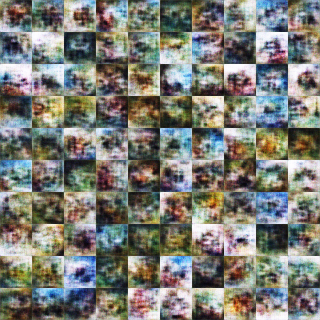

[3/1000][1820/1875][1000] Loss_D: -1281.811646 Loss_G: 1100.130127 
Loss_D_real: 1421.701782 Loss_D_fake -1039.390381 Loss_C_fake 1.703164 304.9083971977234


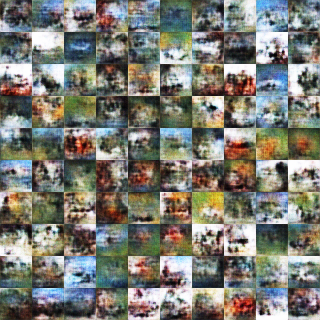

[5/1000][620/1875][1500] Loss_D: -955.200806 Loss_G: 1577.337891 
Loss_D_real: 368.963470 Loss_D_fake -1506.600220 Loss_C_fake 1.133713 412.28650856018066


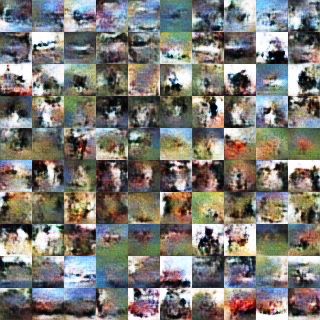

[6/1000][1340/1875][2000] Loss_D: -895.785522 Loss_G: 1918.534302 
Loss_D_real: 193.959839 Loss_D_fake -1405.251465 Loss_C_fake 1.157998 520.6903502941132


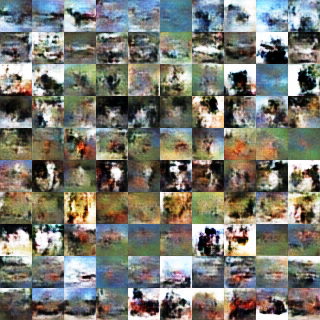

[8/1000][185/1875][2500] Loss_D: -664.638367 Loss_G: 204.860825 
Loss_D_real: 1091.042358 Loss_D_fake -247.308716 Loss_C_fake 1.075660 625.9557673931122


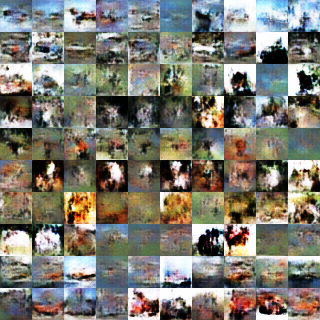

[9/1000][905/1875][3000] Loss_D: -534.632263 Loss_G: -111.890709 
Loss_D_real: 854.598267 Loss_D_fake -278.528015 Loss_C_fake 1.316280 731.2023351192474


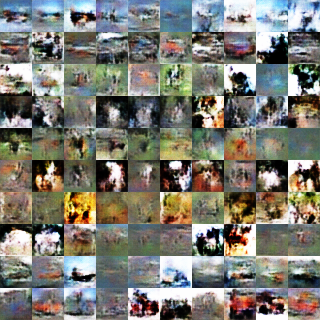

[10/1000][1625/1875][3500] Loss_D: -512.386963 Loss_G: 511.674713 
Loss_D_real: 312.339203 Loss_D_fake -648.575378 Loss_C_fake 0.459010 836.3074288368225


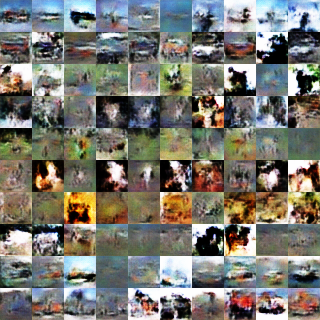

[12/1000][470/1875][4000] Loss_D: -763.041016 Loss_G: 410.196259 
Loss_D_real: 817.306519 Loss_D_fake -435.881226 Loss_C_fake 0.321577 942.9710826873779


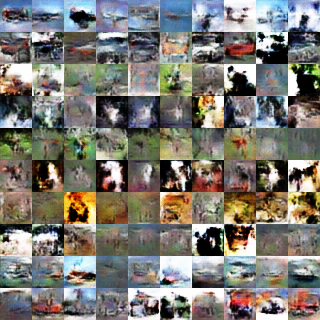

[13/1000][1190/1875][4500] Loss_D: -484.328491 Loss_G: 1563.879639 
Loss_D_real: -360.219513 Loss_D_fake -1251.749634 Loss_C_fake 0.415929 1050.6885874271393


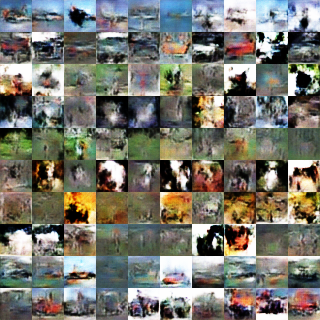

[15/1000][35/1875][5000] Loss_D: -281.242615 Loss_G: 713.924255 
Loss_D_real: -81.246254 Loss_D_fake -766.052429 Loss_C_fake 0.326457 1159.4168813228607


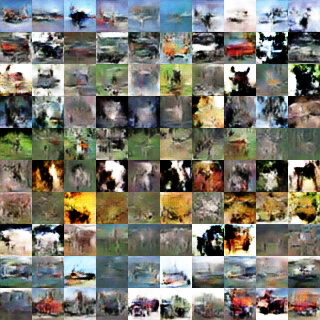

[16/1000][755/1875][5500] Loss_D: -556.008606 Loss_G: -225.272629 
Loss_D_real: 1037.396240 Loss_D_fake 95.534256 Loss_C_fake 0.454791 1270.1476905345917


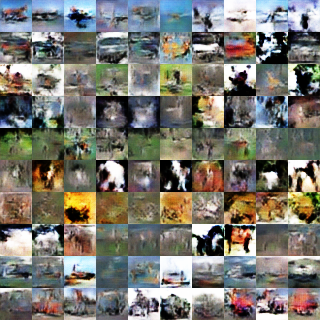

[17/1000][1475/1875][6000] Loss_D: -469.962402 Loss_G: -1049.385010 
Loss_D_real: 1879.548828 Loss_D_fake 1032.650269 Loss_C_fake 0.382915 1379.366274356842


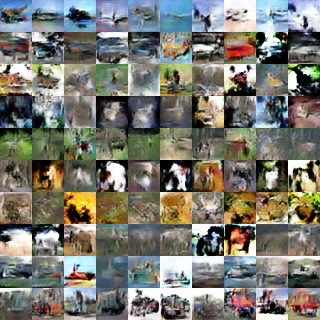

[19/1000][320/1875][6500] Loss_D: -257.040497 Loss_G: 455.903442 
Loss_D_real: 588.309814 Loss_D_fake -23.490503 Loss_C_fake 0.296318 1487.8517348766327


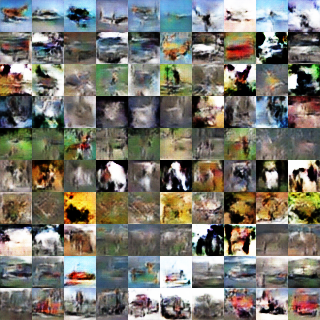

[20/1000][1040/1875][7000] Loss_D: -349.142395 Loss_G: 402.739502 
Loss_D_real: 20.416588 Loss_D_fake -658.036682 Loss_C_fake 0.217879 1596.6471064090729


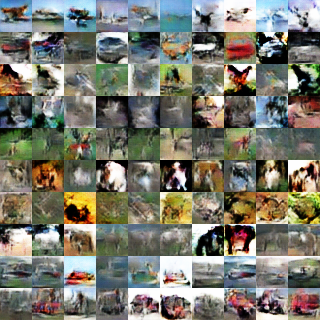

[21/1000][1760/1875][7500] Loss_D: -367.507080 Loss_G: 860.617371 
Loss_D_real: 228.188919 Loss_D_fake -462.697052 Loss_C_fake 0.250450 1703.63960647583


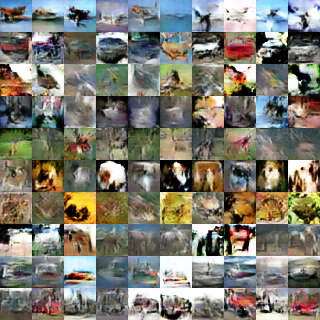

[23/1000][605/1875][8000] Loss_D: -250.801605 Loss_G: 226.089890 
Loss_D_real: 313.113556 Loss_D_fake -244.754517 Loss_C_fake 0.369877 1812.8097486495972


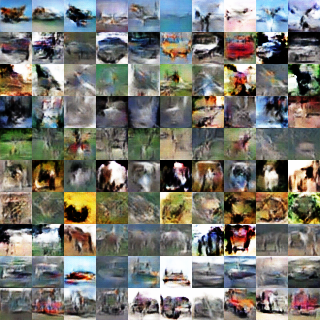

[24/1000][1325/1875][8500] Loss_D: -331.445099 Loss_G: -360.899994 
Loss_D_real: 807.182495 Loss_D_fake 154.175552 Loss_C_fake 0.409341 1920.4692578315735


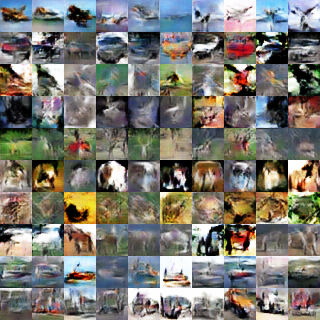

[26/1000][170/1875][9000] Loss_D: -230.748337 Loss_G: -165.513092 
Loss_D_real: 526.704163 Loss_D_fake 30.644506 Loss_C_fake 0.201138 2029.4831264019012


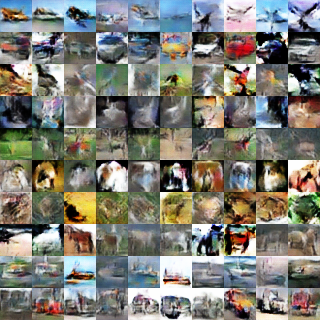

[27/1000][890/1875][9500] Loss_D: -131.696167 Loss_G: 952.584351 
Loss_D_real: -662.969482 Loss_D_fake -1108.952393 Loss_C_fake 0.254982 2135.700788974762


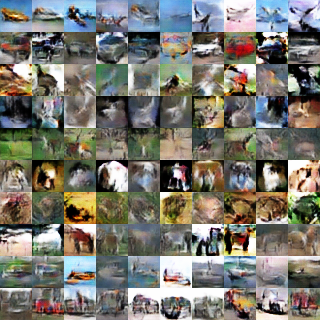

[28/1000][1610/1875][10000] Loss_D: -166.212616 Loss_G: 426.423401 
Loss_D_real: -207.299210 Loss_D_fake -640.465454 Loss_C_fake 0.657851 2242.3386561870575


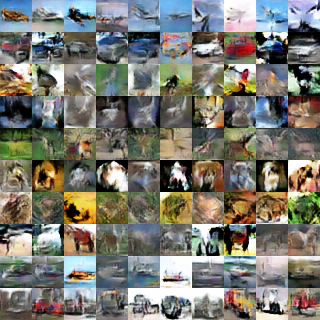

[30/1000][455/1875][10500] Loss_D: -223.378510 Loss_G: 212.378342 
Loss_D_real: 329.364899 Loss_D_fake -130.426865 Loss_C_fake 0.376158 2349.7820217609406


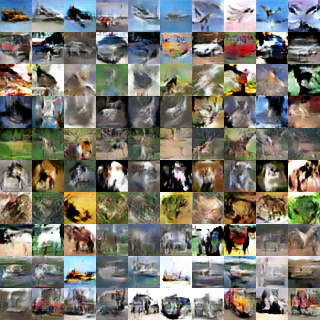

In [ ]:
import time
t0 = time.time()
niter = 1000
gen_iterations = 0
for epoch in range(niter):
    i = 0
    #  每個 epoch 洗牌一下
    #np.random.shuffle(train_X)
    batches = train_X.shape[0]//batchSize
    while i < batches:
        if gen_iterations < 25 or gen_iterations %500 == 0:
            _Diters = 100
        else:
            _Diters = Diters
        j = 0
        while j < _Diters and i < batches:
            j+=1       
            #clamp_D_fn()
            real_data = train_X[i*batchSize:(i+1)*batchSize]
            real_Y = train_Y[i*batchSize:(i+1)*batchSize]
            i+=1        
            noise  = noise_generator(batchSize, nz, n_discrete)
            random_epsilon = np.random.uniform(size=(batchSize, 1,1,1)).astype('float32')
            errD, errD_real, errD_fake, errC_fake = train_D_fn(real_data, noise, real_Y, random_epsilon)
        noise = noise_generator(batchSize, nz, n_discrete)        
        errG = train_G_fn(noise)[0]
        gen_iterations+=1
        if gen_iterations%500==0:
            print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f \nLoss_D_real: %f Loss_D_fake %f Loss_C_fake %f'
            % (epoch, niter, i, batches, gen_iterations,
            errD, errG, errD_real, errD_fake, errC_fake), time.time()-t0)
        if gen_iterations%500 == 0:            
            fake = generator_fn(fixed_noise)
            showX(fake, 10)
        